In [3]:
#Supplier Performance using synthetic data
#Aaron Bond

In [58]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib.ticker import FuncFormatter


In [93]:
#generate dataset
num_suppliers=100
np.random.seed(111)
df=pd.DataFrame()

#function to generate dataset
def generate_row():
    quality=random.randrange(1,10)
    timeliness=random.randrange(1,10)
    flexibility=random.randrange(1,10)
    business_volume=random.randrange(1,100000)
    category=np.random.randint(0,3)
    method_of_payment=np.random.randint(0,3)
    number_of_employees=np.random.randint(0,51)
    return[quality,timeliness,flexibility,business_volume, category, method_of_payment]

def generate_purchase_orders():
    supplier_id=np.random.randint(1,num_suppliers+1)
    quantity=random.randrange(1,100)
    unit_cost=random.randrange(1,1000)
    return[supplier_id,quantity,unit_cost]

vendor_list=pd.DataFrame(list(range(0,num_suppliers+1)))
vendor_list.columns=['Supplier ID']

#generate vendor list
suppliers=[generate_row() for _ in range(num_suppliers)]
vendors=pd.DataFrame(suppliers)
vendors.columns=['Quality','Timeliness','Flexibility','Business Volume','Category','Method of Payment']
vendors.loc[vendors['Category']==0,'Category']='Service'
vendors.loc[vendors['Category']==1,'Category']='Raw Materials'
vendors.loc[vendors['Category']==2,'Category']='Labor'
vendors.loc[vendors['Method of Payment']==0,'Method of Payment']='Cash in Advance'
vendors.loc[vendors['Method of Payment']==1,'Method of Payment']='Line of Credit'
vendors.loc[vendors['Method of Payment']==2,'Method of Payment']='Net Terms'
df_supplier=pd.merge(vendor_list,vendors,left_index=True,right_index=True)

#generate purchase orders
purchase_orders=[generate_purchase_orders() for _ in range (100000)]
POs=pd.DataFrame(purchase_orders)
POs.columns=['Supplier ID','Quantity','Unit Cost']

#merge dataframes
data=POs.merge(df_supplier,left_on='Supplier ID',right_on='Supplier ID', how='left')
data['Total Cost']=data['Unit Cost']*data['Quantity']
data.head()

C:\Users\aaron\AppData\Local\Temp\ipykernel_27432\1231834503.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Service' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vendors.loc[vendors['Category']==0,'Category']='Service'
C:\Users\aaron\AppData\Local\Temp\ipykernel_27432\1231834503.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cash in Advance' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vendors.loc[vendors['Method of Payment']==0,'Method of Payment']='Cash in Advance'


,Supplier ID,Quantity,Unit Cost,Quality,Timeliness,Flexibility,Business Volume,Category,Method of Payment,Total Cost
0,5,59,894,3.0,7.0,6.0,2.0,Service,Cash in Advance,52746
1,44,45,462,2.0,6.0,3.0,70589.0,Raw Materials,Cash in Advance,20790
2,15,98,858,4.0,5.0,2.0,93544.0,Labor,Line of Credit,84084
3,41,90,824,9.0,4.0,9.0,89266.0,Service,Cash in Advance,74160
4,98,27,117,9.0,3.0,9.0,90843.0,Service,Cash in Advance,3159


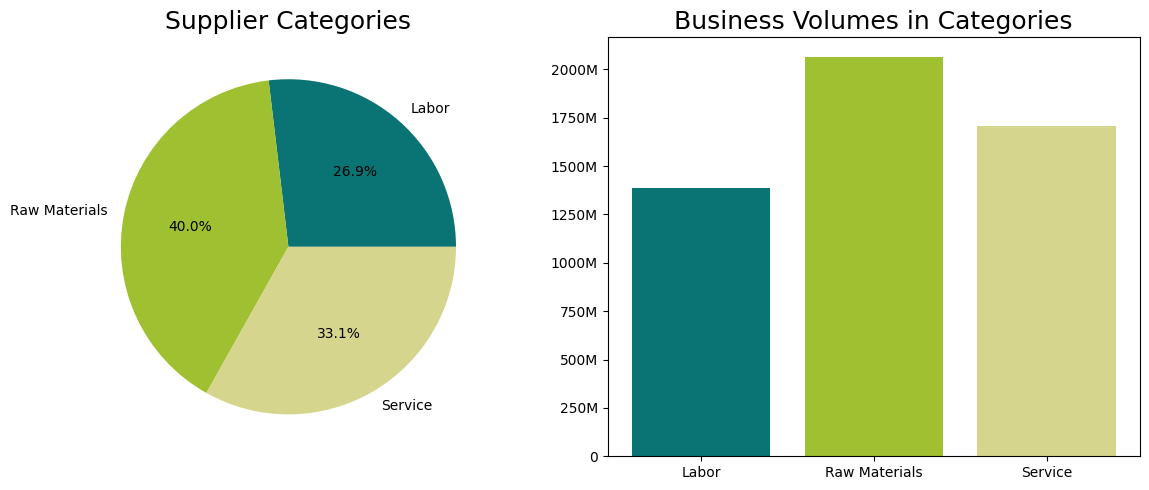

In [100]:
#Group Data by Category
category_df=data.groupby(['Category'])['Business Volume'].sum().reset_index()
category_df.head()

#visualize categories
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.pie(category_df['Business Volume'],labels=category_df['Category'].value_counts().index,autopct='%1.1f%%',colors=['#0A7373', '#9FC131', '#D6D58E'])
ax1.set_title('Supplier Categories', fontsize=18)

bars = ax2.bar(category_df['Category'], category_df['Business Volume'], color=['#0A7373', '#9FC131', '#D6D58E'])
ax2.set_title('Business Volumes in Categories', fontsize=18)
ax2.ticklabel_format(style='plain', axis='y')

def y_axis_formatter(x,pos):
    if x>=1000000:
        return f'{int(x/1000000)}M'
    else:
        return int(x)

ax2.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.tight_layout()
plt.show()

In [95]:
#Group by Number of PO's
vendor_po_df=data.groupby(['Supplier ID']).agg({'Total Cost':['mean','min','max','sum']}).reset_index()
vendor_po_df.columns=['Supplier ID','mean PO Spend', 'min PO Spend','max PO Spend','Total PO Spend']

vendor_po_count_df=data.groupby(['Supplier ID'])['Quantity'].count().reset_index()
vendor_po_count_df.columns=['Supplier ID','Number of PO']

vendor_purchase_orders=vendor_po_df.merge(vendor_po_count_df, how='left',left_on='Supplier ID',right_on='Supplier ID')
vendor_purchase_orders=vendor_purchase_orders.merge(df_supplier,how='left', left_on='Supplier ID',right_on='Supplier ID')
vendor_purchase_orders.drop(columns=['Business Volume'],inplace=True)
vendor_purchase_orders.head()

,Supplier ID,mean PO Spend,min PO Spend,max PO Spend,Total PO Spend,Number of PO,Quality,Timeliness,Flexibility,Category,Method of Payment
0,1,25432.881620,30,95424,24491865,963,8.0,3.0,4.0,Service,Net Terms
1,2,25732.755330,26,98307,25346764,985,5.0,2.0,4.0,Raw Materials,Net Terms
2,3,24110.046092,13,95238,24061826,998,3.0,1.0,7.0,Service,Line of Credit
3,4,24594.772947,58,89768,25455590,1035,1.0,3.0,9.0,Service,Net Terms
4,5,24358.057495,22,93624,23724748,974,3.0,7.0,6.0,Service,Cash in Advance


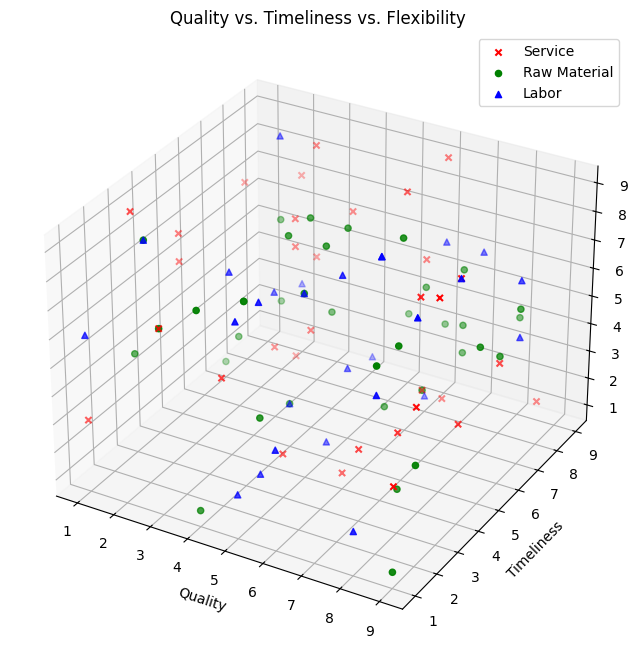

In [111]:
#Supplier Characteristics

#filter by category
service=vendor_purchase_orders.loc[vendor_purchase_orders['Category'] == 'Service']
rawmaterial=vendor_purchase_orders.loc[vendor_purchase_orders['Category'] == 'Raw Materials']
labor=vendor_purchase_orders.loc[vendor_purchase_orders['Category'] == 'Labor']

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection='3d')
ax.scatter(service['Quality'],service['Timeliness'],service['Flexibility'], c='r',label='Service', marker='x')
ax.scatter(rawmaterial['Quality'],rawmaterial['Timeliness'],rawmaterial['Flexibility'], c='green',label='Raw Material',marker='o')
ax.scatter(labor['Quality'],labor['Timeliness'],labor['Flexibility'], c='b',label='Labor', marker='^')

ax.set_xlabel('Quality')
ax.set_ylabel('Timeliness')
ax.set_zlabel('Flexibility')

ax.legend()

plt.title("Quality vs. Timeliness vs. Flexibility")
plt.show()